In [1]:
#import library
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#load the dataset
#Black pod rot dataset
folder_path_black_pod_rot = '/content/drive/MyDrive/Capstone/cocoa_diseases/black_pod_rot'
item_black_pod_rot = os.listdir(folder_path_black_pod_rot)
count_black_pod_rot = len(item_black_pod_rot)

#Healthy
folder_path_healthy = '/content/drive/MyDrive/Capstone/cocoa_diseases/healthy'
item_healthy = os.listdir(folder_path_healthy)
count_healthy = len(item_healthy)

#pod_borer
folder_path_pod_borer = '/content/drive/MyDrive/Capstone/cocoa_diseases/pod_borer'
item_pod_borer = os.listdir(folder_path_pod_borer)
count_pod_borer = len(item_pod_borer)

print(f"Amount black pod rot items in folder: {count_black_pod_rot}")
print(f"Amount healthy items in folder: {count_healthy}")
print(f"Amount pod borer items in folder: {count_pod_borer}")

Amount black pod rot items in folder: 500
Amount healthy items in folder: 500
Amount pod borer items in folder: 208


In [3]:
#define paths
source_dir = '/content/drive/MyDrive/Capstone'
train_dir = os.path.join(source_dir, 'train')
test_dir = os.path.join(source_dir, 'test')
validation_dir = os.path.join(source_dir, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [4]:
#splitting data
#define the class names
data_dir = '/content/drive/MyDrive/Capstone/cocoa_diseases'
class_names = ['black_pod_rot', 'healthy', 'pod_borer']

#define the desired split ratios (adjust as needed)
train_ratio = 0.8  # 80% for training
test_ratio = 0.1   # 20% for testing
valid_ratio = 0.1  # 10% for validation

#iterate over each class directory
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)
    total_images = len(images)

    # Split the images into train, test, and validation sets
    train_split = int(train_ratio * total_images)
    test_split = int((train_ratio + test_ratio) * total_images)

    train_images = images[:train_split]
    test_images = images[train_split:test_split]
    valid_images = images[test_split:]

    # Move images to respective directories
    for image in train_images:
        src_path = os.path.join(class_dir, image)
        dst_path = os.path.join(train_dir, class_name, image)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for image in test_images:
        src_path = os.path.join(class_dir, image)
        dst_path = os.path.join(test_dir, class_name, image)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for image in valid_images:
        src_path = os.path.join(class_dir, image)
        dst_path = os.path.join(validation_dir, class_name, image)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

#function to count the number of files in a directory
def count_files(directory):
    count = sum([len(files) for r, d, files in os.walk(directory)])
    return count

#count the number of files in each directory
data_count = count_files(data_dir)
train_count = count_files(train_dir)
test_count = count_files(test_dir)
valid_count = count_files(validation_dir)

#print the results
print("Total data count:", data_count)
print("Train data count:", train_count)
print("Test data count:", test_count)
print("Validation data count:", valid_count)

Total data count: 1208
Train data count: 1208
Test data count: 722
Validation data count: 712


In [5]:
#standarizing images
def train_val_generators(train_dir, test_dir, validation_dir):

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))
  
  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  test_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
  
  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
  return train_generator, test_generator, validation_generator

train_generator, test_generator, validation_generator = train_val_generators(train_dir, test_dir, validation_dir)

Found 1208 images belonging to 3 classes.
Found 722 images belonging to 3 classes.
Found 712 images belonging to 3 classes.


In [6]:
#creating model
def create_model():
  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2), 
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(256, activation='relu'), 
      tf.keras.layers.Dense(512, activation='relu'), 
      tf.keras.layers.Dense(3, activation='softmax'),
  ])

  from tensorflow.keras.optimizers import Adam 
  model.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
  return model

model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [7]:
#training the model
history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/50
38/38 [==============================] - 285s 7s/step - loss: 1.0644 - accuracy: 0.4230 - val_loss: 1.0270 - val_accuracy: 0.4017
Epoch 2/50
38/38 [==============================] - 18s 466ms/step - loss: 1.0083 - accuracy: 0.4379 - val_loss: 1.0136 - val_accuracy: 0.4228
Epoch 3/50
38/38 [==============================] - 19s 504ms/step - loss: 0.9816 - accuracy: 0.4147 - val_loss: 0.8992 - val_accuracy: 0.4775
Epoch 4/50
38/38 [==============================] - 18s 472ms/step - loss: 0.9573 - accuracy: 0.4619 - val_loss: 0.9030 - val_accuracy: 0.4846
Epoch 5/50
38/38 [==============================] - 19s 498ms/step - loss: 0.9218 - accuracy: 0.4992 - val_loss: 0.8978 - val_accuracy: 0.4747
Epoch 6/50
38/38 [==============================] - 18s 468ms/step - loss: 0.8863 - accuracy: 0.5075 - val_loss: 0.8420 - val_accuracy: 0.5548
Epoch 7/50
38/38 [==============================] - 18s 466ms/step - loss: 0.8940 - accuracy: 0.5224 - val_loss: 0.8165 - val_accuracy: 0.5506
E

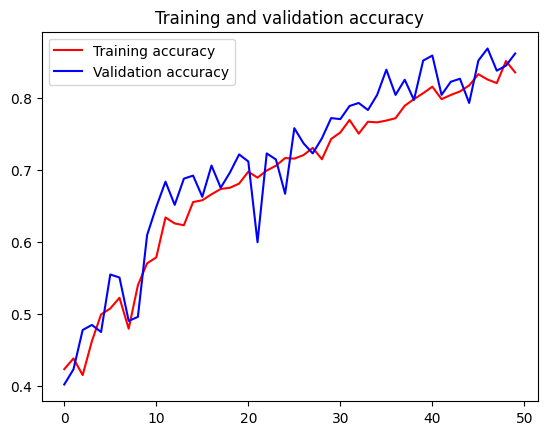

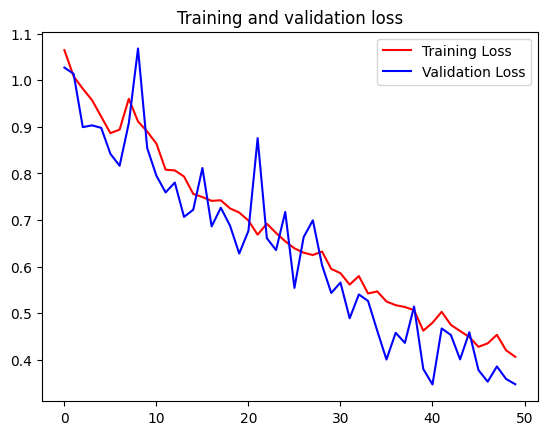

In [8]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
#Evaluating the model
val_loss, val_acc = model.evaluate(validation_generator)
print('Validation Loss: ',val_loss),
print('Validation Accuracy: ',val_acc)

23/23 [==============================] - 4s 172ms/step - loss: 0.3477 - accuracy: 0.8624
Validation Loss:  0.3477340340614319
Validation Accuracy:  0.8623595237731934
